In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [410]:
sub_process_names = [
    'Effluent treatment',
    'Li recovery',
    'Ni recovery',
    'Co recovery',
    'Mn recovery',
    'Solution purification',
    'Leaching',
    'Total'
]

In [411]:
def parse_contribution_tree(scenario):
    # Read the Excel file into a DataFrame
    df = pd.read_excel('contribution_tree.xlsx', 'Upstream tree')

    # Get the impact category and unit as the dataset name
    labels = df.columns[0].split(':')
    category = ','.join(labels[1:])[1:]
    unit = df.iloc[0][8]
    unit = unit[unit.find('[')+1:unit.find(']')]
    unit = ''.join(['[', unit, ']'])
    name = ''.join([category, ' ', unit])

    # Initialize variables
    processes = []
    final_rows = []
    current_subprocess_level = -1

    # Iterate through the rows of the dataframe
    for i, row in df.iterrows():
        # Replace nan by 0 in 'Direct contributions' column
        if pd.isna(row.iloc[-1]):
            row.iloc[-1] = 0

        # Determine the level by checking which cell is filled in the row
        level = next((j for j in range(len(row)) if not pd.isna(row[j])), len(row))
        if level == current_subprocess_level:
            current_subprocess_level -= 1

        # Check if the current row is a subprocess
        if row[level].startswith(scenario):
            current_subprocess_level = level
            row['Level'] = level
            final_rows.append(row.dropna().values)

        # Check if the row is an activity and needs to be retained
        elif not pd.isna(row[level]):
            # Check if the activity is directly under a subprocess
            if level - 1 == current_subprocess_level:
                # Direct child of a subprocess
                row['Level'] = level
                final_rows.append(row.dropna().values)

    # Create a new DataFrame from the filtered rows
    final_rows[0][-1] = 'Level'
    final_df = pd.DataFrame(final_rows)
    final_df.columns = final_df.iloc[0]
    final_df = final_df[1:]

    return name, final_df

In [412]:
def parse_sub_processes(df, sub_process_names):
    sub_process_totals = []
    sub_processes = []

    # Extract sub-process 'totals' (e.g. 'Leaching')
    for i, row in df.iterrows():
        # print(row['Level'])
        # print(sub_process_names[7 - row['Level']])
        df.loc[i, 'Sub-process'] = sub_process_names[row['Level'] - 1]
        if row[0].startswith('Baseline'):
            sub_process_totals.append(row)
            df.drop(index=i, inplace=True)
    sub_process_totals = pd.DataFrame(sub_process_totals, columns=df.columns)
    
    # Group sub-processes
    for i, g in df.groupby('Level'):
        sub_processes.append(g)
    
    return sub_process_totals, sub_processes

In [413]:
def parse_process_names(processes):
    for p in processes:
        for i, row in p.iterrows():
            split_row = row[0].split(' | ')
            p.loc[i, 'Processes'] = split_row[0]
            if row[0].startswith('market for'):
                p.loc[i, 'Processes'] = row[0][11:]
            if row[0].startswith('market group for'):
                p.loc[i, 'Processes'] = row[0][17:]
            if row[0].endswith('production'):
                p.loc[i, 'Processes'] = row[0][:-11]

    return processes

In [414]:
def pop_col(indices, cols, new_cols):
    for i in indices:
        col = cols[i]
        new_cols.append(col)
        cols[i] = ''

    return cols, new_cols

In [415]:
def arrange_by_value(df):
    cols = df.columns
    negative = []
    positive = []

    for col in cols:
        if df[col].any() < 0:
            negative.append(col)
        else:
            positive.append(col)
    
    new_cols = positive + negative

    return new_cols

In [416]:
category, contributions = parse_contribution_tree('Baseline')
sub_process_totals, sub_processes = parse_sub_processes(contributions, sub_process_names)

c:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [417]:
sub_processes[0]

,Processes,Result [kg P-Eq],Direct contribution [kg P-Eq],Level,Sub-process
2,"market group for electricity, medium voltage |...",0.129599,0,1,Effluent treatment
3,"market for hazardous waste, for underground de...",0.048848,0,1,Effluent treatment
4,"market for wastewater, average | wastewater, a...",0.006315,0.002092,1,Effluent treatment
5,"market for quicklime, milled, packed | quickli...",0.001335,0,1,Effluent treatment
6,"market for wastewater, unpolluted | wastewater...",0.000319,0,1,Effluent treatment
7,market group for tap water | tap water | Cutof...,0.000266,0,1,Effluent treatment


In [418]:
category

'Eutrophication, freshwater [kg P-Eq]'

In [419]:
parsed = parse_process_names(sub_processes)

In [420]:
parsed[0]

,Processes,Result [kg P-Eq],Direct contribution [kg P-Eq],Level,Sub-process
2,"electricity, medium voltage",0.129599,0,1,Effluent treatment
3,"hazardous waste, for underground deposit",0.048848,0,1,Effluent treatment
4,"wastewater, average",0.006315,0.002092,1,Effluent treatment
5,"quicklime, milled, packed",0.001335,0,1,Effluent treatment
6,"wastewater, unpolluted",0.000319,0,1,Effluent treatment
7,tap water,0.000266,0,1,Effluent treatment


In [421]:
combined_df = pd.concat(sub_processes)
combined_df = combined_df[::-1].reset_index(drop=True)

In [422]:
pivot_df = combined_df.pivot(index='Sub-process', columns='Processes', values=combined_df.columns[1]).fillna(0)
pivot_df = pivot_df.reindex(index=combined_df['Sub-process'].unique(), columns=combined_df['Processes'].unique())

#-------------------------------------------------------------------------------
# Write all the processes you want to omit from the figure in the list below
#-------------------------------------------------------------------------------
dropped = [
    'nickel sulfate'
]

#-------------------------------------------------------------------------------
# Comment or uncomment the following line to plot all or only those w\o
#  'dropped'
#-------------------------------------------------------------------------------
# pivot_df.drop(['nickel sulfate', 'cobalt sulfate'], axis=1, inplace=True)

pivot_df

Processes,tap water,"electricity, medium voltage",sulfuric acid,"hydrogen peroxide, without water, in 50% solution state","copper concentrate, sulfide ore",hydrogen sulfide,"hazardous waste, for underground deposit","sodium hydroxide, without water, in 50% solution state","transport, freight train","transport, freight, lorry, unspecified",...,D2EHPA,cobalt sulfate,Cyanex 272,nickel sulfate,lithium carbonate,"sodium sulfate, anhydrite","soda ash, dense","wastewater, unpolluted","quicklime, milled, packed","wastewater, average"
Sub-process,,,,,,,,,,,,,,,,,,,,,
Leaching,0.000787,0.031597,0.052118,0.106658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Solution purification,0.000172,0.093909,0.000000,0.000002,-0.539742,0.003271,0.047577,0.108718,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Mn recovery,0.000108,0.058510,0.007707,0.000000,0.000000,0.000000,0.000000,0.012814,0.000024,0.000068,...,0.362614,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Co recovery,0.000145,0.050365,0.008157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.709422,0.05256,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Ni recovery,0.000301,0.039339,0.025067,0.000000,0.000000,0.000000,0.000000,0.088821,0.000000,0.000000,...,0.627167,0.000000,0.00000,-3.07777,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Li recovery,0.000324,0.138736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,-0.817539,-0.40334,0.471313,0.000000,0.000000,0.000000
Effluent treatment,0.000266,0.129599,0.000000,0.000000,0.000000,0.000000,0.048848,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000319,0.001335,0.006315


In [423]:
#-------------------------------------------------------------------------------
# In this cell, the flows/processes will be rearranged so that positive values
#  will be first, and negative last.
#
# Alternatively, use the list 'indices' to define the order of columns (flows/
#  processes) in your legend manually.
#
# Run this cell to apply the changes and see the available indices, as well your
#  new list of flow/processes.
#
# Run the previous cell to reset the list variables.
#
# Run the next cell to plot the figure, and see the legend.
#-------------------------------------------------------------------------------

cols = pivot_df.columns.to_list()
used_cols = cols.copy()
new_cols = []

# new_cols = arrange_by_value(pivot_df)

# Modify this list. See the available indices below by running this cell.
# indices = []
indices = [18, 15, 7, 8, 14, 13, 1, 0, 9, 19, 17, 4, 5, 6, 20, 21, 16, 3, 11, 2, 12, 10]

used_cols, new_cols = pop_col(indices, used_cols, new_cols)
print('remaining:')
for i, col in enumerate(used_cols):
    print(i, col)

print('\ncurrent:')
for i, col in enumerate(new_cols):
    print(col)

remaining:
0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 wastewater, unpolluted
23 quicklime, milled, packed
24 wastewater, average

current:
nickel sulfate
D2EHPA
sodium hydroxide, without water, in 50% solution state
transport, freight train
hazardous waste, for incineration
steam, in chemical industry
electricity, medium voltage
tap water
transport, freight, lorry, unspecified
lithium carbonate
Cyanex 272
copper concentrate, sulfide ore
hydrogen sulfide
hazardous waste, for underground deposit
sodium sulfate, anhydrite
soda ash, dense
cobalt sulfate
hydrogen peroxide, without water, in 50% solution state
manganese sulfate
sulfuric acid
kerosene
chlor-alkali electrolysis, average


In [424]:
pivot_df = pivot_df[new_cols]
# pivot_df = pivot_df.reindex(sub_process_names[:-1][::-1])
pivot_df

Processes,nickel sulfate,D2EHPA,"sodium hydroxide, without water, in 50% solution state","transport, freight train","hazardous waste, for incineration","steam, in chemical industry","electricity, medium voltage",tap water,"transport, freight, lorry, unspecified",lithium carbonate,...,hydrogen sulfide,"hazardous waste, for underground deposit","sodium sulfate, anhydrite","soda ash, dense",cobalt sulfate,"hydrogen peroxide, without water, in 50% solution state",manganese sulfate,sulfuric acid,kerosene,"chlor-alkali electrolysis, average"
Sub-process,,,,,,,,,,,,,,,,,,,,,
Leaching,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031597,0.000787,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.106658,0.000000,0.052118,0.000000,0.000000
Solution purification,0.00000,0.000000,0.108718,0.000000,0.000000,0.000000,0.093909,0.000172,0.000000,0.000000,...,0.003271,0.047577,0.00000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000
Mn recovery,0.00000,0.362614,0.012814,0.000024,0.032640,0.010761,0.058510,0.000108,0.000068,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-0.030134,0.007707,0.002422,0.080292
Co recovery,0.00000,0.000000,0.000000,0.000000,0.035149,0.006109,0.050365,0.000145,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,-1.709422,0.000000,0.000000,0.008157,0.001775,0.000000
Ni recovery,-3.07777,0.627167,0.088821,0.000000,0.052142,0.012990,0.039339,0.000301,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.025067,0.002793,0.000000
Li recovery,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138736,0.000324,0.000000,-0.817539,...,0.000000,0.000000,-0.40334,0.471313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Effluent treatment,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129599,0.000266,0.000000,0.000000,...,0.000000,0.048848,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [425]:
# A couple of manual tidy-ups to the column names
pivot_df.rename({'sodium hydroxide, without water, in 50% solution state': 'sodium hydroxide'}, axis=1, inplace=True)
pivot_df.rename({'hydrogen peroxide, without water, in 50% solution state': 'hydrogen peroxide'}, axis=1, inplace=True)

C:\Users\lappalh1\AppData\Local\Temp\ipykernel_17868\2924613575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df.rename({'sodium hydroxide, without water, in 50% solution state': 'sodium hydroxide'}, axis=1, inplace=True)
C:\Users\lappalh1\AppData\Local\Temp\ipykernel_17868\2924613575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df.rename({'hydrogen peroxide, without water, in 50% solution state': 'hydrogen peroxide'}, axis=1, inplace=True)


In [426]:
# Define the colormap
positive_colors = mpl.colormaps['Oranges_r'].resampled(148)
negative_colors = mpl.colormaps['Blues'].resampled(108)

new_colors = np.vstack((
    positive_colors(np.linspace(0, 1, 158)),
    negative_colors(np.linspace(0, 1, 98))
))

# my_cmap = mpl.colors.ListedColormap(new_colors)
my_cmap = mpl.colormaps['tab20b']

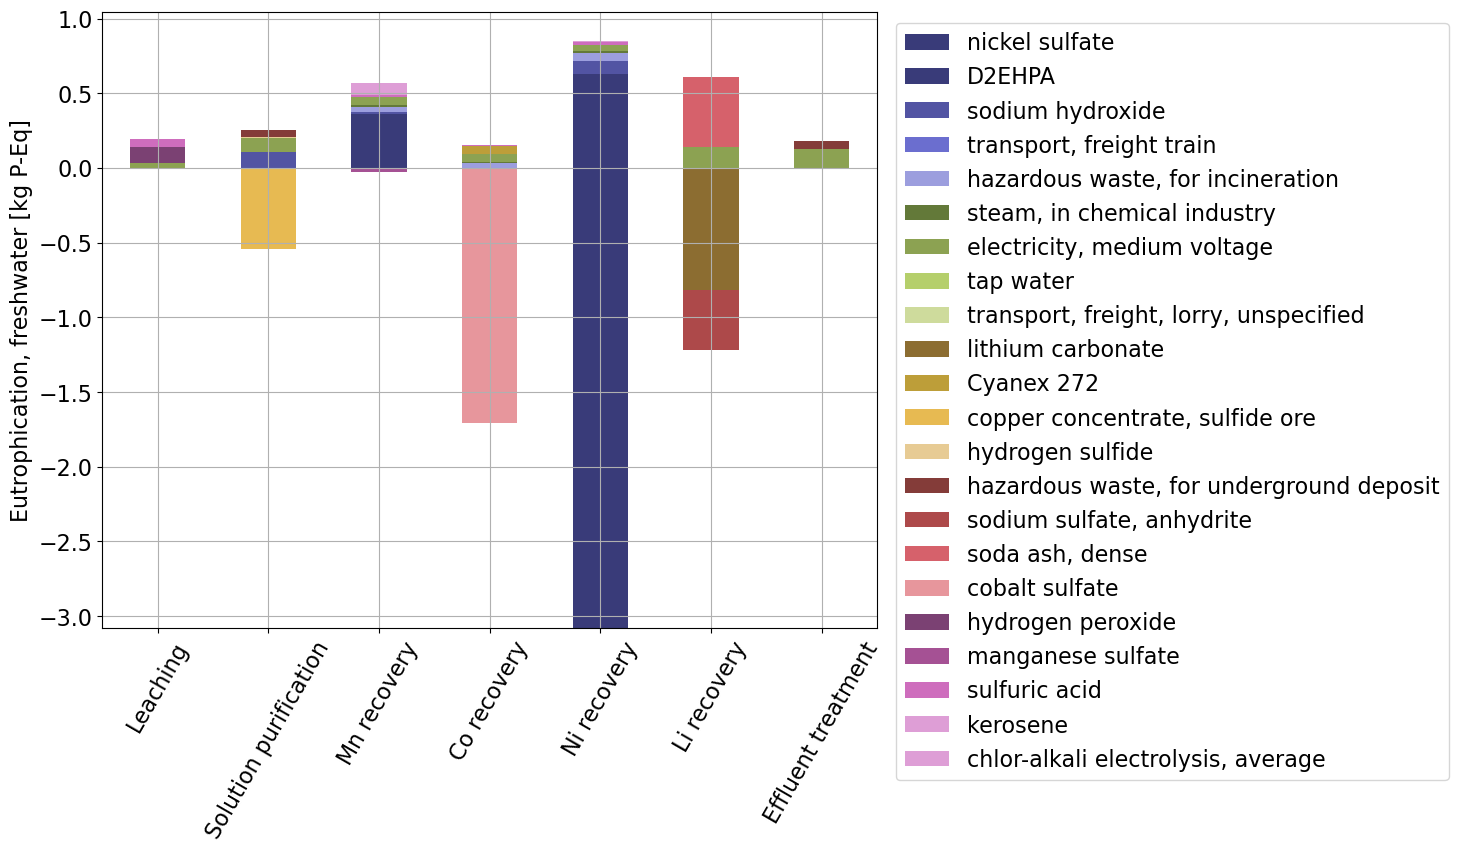

In [427]:
fig, ax = plt.subplots(figsize=(10, 8))

pivot_df.plot.bar(stacked=True, grid=True, ax=ax, cmap=my_cmap)
plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.xlabel('')
plt.xticks(rotation=60)
plt.ylabel(category)
mpl.rcParams.update({'font.size': 16})

plt.show()